## 分析1：週間評価フェーズにおける SPI 改善効果の検証

本分析の目的は、直近7日間において3日以上実績が存在する
「週間評価フェーズ」に限定し、実績入力（行動）が
SPI（Schedule Performance Index）を改善する方向に作用しているかを検証することである。

短期評価フェーズ（実績日数が3日未満）では、
SPI の数値的意味が週間評価フェーズと異なるため、
本分析では対象外とする。

node export-daily-logs.cjs

### 分析対象データの条件

以下の条件をすべて満たす日次データのみを分析対象とする。

- SPI_before, SPI_after の両方が週間評価フェーズ
  （直近7日間の実績日数 ≥ 3）
- 当日時点で SPI_before < 1
  （安全とは言えない状態）
- dSPI = SPI_after − SPI_before ≠ 0

In [9]:
# === Cell 1: Setup & Load (daily_logs.csv) ===
import pandas as pd
import numpy as np

df = pd.read_csv("daily_logs.csv")
df.columns = [c.strip() for c in df.columns]  # 念のため

# 列名を統一（分析では taskId という名前で扱う）
df = df.rename(columns={
    "todoId": "taskId",
    "deadlineDate": "dueDate",
    "estimatedMinutes": "estimateMinutes",
    "createdDate": "createdAt",
})

# ログインフラグをマージ（列がない場合は0）
df["loginFlag"] = pd.to_numeric(df.get("loginFlag", 0), errors="coerce").fillna(0).astype(int)
df["firstLoginAtJst"] = pd.to_datetime(df.get("firstLoginAtJst"), errors="coerce")

# 完了情報（列が無ければ欠損として扱う）
df["completed"] = pd.to_numeric(df.get("completed", 0), errors="coerce").fillna(0).astype(int)
df["completedAt"] = pd.to_datetime(df.get("completedAt"), errors="coerce")

# 型変換
df["date"] = pd.to_datetime(df["date"])
df["dueDate"] = pd.to_datetime(df["dueDate"])
df["createdAt"] = pd.to_datetime(df.get("createdAt"), errors="coerce")
df["minutes"] = pd.to_numeric(df["minutes"], errors="coerce").fillna(0.0)
df["estimateMinutes"] = pd.to_numeric(df["estimateMinutes"], errors="coerce")

# 日付の正規化列（フィルタ用）
df["date_only"] = df["date"].dt.normalize()
df["dueDate_only"] = df["dueDate"].dt.normalize()
df["completedDate"] = df["completedAt"].dt.normalize()

# 並べ替え
df = df.sort_values(["taskId", "date"]).reset_index(drop=True)

# 確認
print("rows:", len(df), "tasks:", df["taskId"].nunique())
print("columns:", list(df.columns))
display(df.head())
display(df[["minutes", "estimateMinutes", "loginFlag"]].describe())


rows: 241 tasks: 60
columns: ['taskId', 'userId', 'date', 'minutes', 'estimateMinutes', 'dueDate', 'createdAt', 'text', 'loginFlag', 'firstLoginAtJst']


,taskId,userId,date,minutes,estimateMinutes,dueDate,createdAt,text,loginFlag,firstLoginAtJst
0,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-18,5,250,2026-03-20,2025-12-18,タイピング練習,1,2025-12-18 06:16:37
1,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-19,10,250,2026-03-20,2025-12-18,タイピング練習,1,2025-12-19 00:00:07
2,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-22,25,250,2026-03-20,2025-12-18,タイピング練習,1,2025-12-22 07:02:49
3,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-24,80,250,2026-03-20,2025-12-18,タイピング練習,1,2025-12-24 12:02:09
4,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-28,80,250,2026-03-20,2025-12-18,タイピング練習,1,2025-12-28 14:18:53


,minutes,estimateMinutes,loginFlag
count,241.000000,241.000000,241.000000
mean,126.385892,5307.128631,0.692946
std,128.632116,6406.162263,0.462232
min,0.000000,3.000000,0.000000
25%,30.000000,120.000000,0.000000
50%,90.000000,1440.000000,1.000000
75%,180.000000,15000.000000,1.000000
max,1000.000000,15000.000000,1.000000


In [10]:
# === Cell 2: Compute required / pace7d(before/after) / SPI(before/after) ===


def pace7d_with_rule(last7_minutes):
    """
    last7_minutes: 長さ<=7の配列（直近→過去ではなく、時間順でOK）
    ルール:
      - sum7 = 直近7日のminutes合計（0も含める）
      - daysWorked = minutes>0 の日数
      - denom = max(1, daysWorked<3 ? daysWorked : 7)
      - pace7d = sum7 / denom
      - isShortWindow = (daysWorked < 3)
    """
    last7 = np.array(last7_minutes, dtype=float)
    sum7 = float(np.nansum(last7))
    daysWorked = int(np.sum(last7 > 0))
    denom = max(1, daysWorked if daysWorked < 3 else 7)
    pace = sum7 / denom
    isShort = daysWorked < 3
    return pace, daysWorked, denom, isShort


rows = []

for taskId, g in df.groupby("taskId"):
    g = g.sort_values("date").reset_index(drop=True)

    minutes = g["minutes"].to_numpy(dtype=float)
    est = float(g["estimateMinutes"].iloc[0])
    due = g["dueDate"].iloc[0]

    # 累積（before=当日除外, after=当日含む）
    cum_after = np.cumsum(minutes)
    cum_before = np.concatenate([[0.0], cum_after[:-1]])

    # 当日朝時点の残量（before基準）
    remaining = np.maximum(0.0, est - cum_before)

    # 残日数（当日含む。最低1）
    days_left = np.array([(due - dt).days for dt in g["date"]], dtype=float)
    days_left = np.maximum(1.0, days_left)

    # required（当日朝時点の必要ペース）
    required = np.where(remaining > 0, remaining / days_left, 0.0)

    pace_before = np.zeros(len(g), dtype=float)
    pace_after = np.zeros(len(g), dtype=float)
    isShort_before = np.zeros(len(g), dtype=bool)
    isShort_after = np.zeros(len(g), dtype=bool)

    # 各日について「直近7日」を作って pace を計算
    # before: 当日を0として直近7日（= i-6..i のうち、当日は0扱い）
    # after : 当日実績を含めて直近7日
    for i in range(len(g)):
        start = max(0, i - 6)
        window_after = minutes[start : i + 1].copy()
        window_before = window_after.copy()
        window_before[-1] = 0.0  # 当日は未入力扱い

        p_b, _, _, s_b = pace7d_with_rule(window_before)
        p_a, _, _, s_a = pace7d_with_rule(window_after)

        pace_before[i] = p_b
        pace_after[i] = p_a
        isShort_before[i] = s_b
        isShort_after[i] = s_a

    # SPI（required=0の扱いもアプリ寄せ）
    # remaining=0 ならSPI=1、それ以外で required=0 は SPI=0
    spi_before = np.where(
        required > 0,
        pace_before / required,
        np.where(remaining == 0, 1.0, 0.0),
    )
    spi_after = np.where(
        required > 0,
        pace_after / required,
        np.where(remaining == 0, 1.0, 0.0),
    )

    out = g.copy()
    out["cum_before"] = cum_before
    out["cum_after"] = cum_after
    out["remaining_before"] = remaining
    out["daysLeft"] = days_left
    out["required"] = required

    out["pace7d_before"] = pace_before
    out["pace7d_after"] = pace_after
    out["isShortWindow_before"] = isShort_before
    out["isShortWindow_after"] = isShort_after

    out["SPI_before"] = spi_before
    out["SPI_after"] = spi_after
    out["dSPI"] = out["SPI_after"] - out["SPI_before"]

    rows.append(out)

calc = pd.concat(rows, ignore_index=True)

# 追加フィルタ: 締切超過で未完了のデータ、および締切日当日に完了したデータを除外
calc["date_only"] = calc["date"].dt.normalize()
calc["dueDate_only"] = calc["dueDate"].dt.normalize()
calc["completedDate"] = calc["completedAt"].dt.normalize()
calc["is_due_known"] = calc["dueDate_only"].notna()
calc["is_completed"] = calc["completedDate"].notna()
calc["is_completed_on_due_day"] = (
    calc["is_due_known"]
    & calc["is_completed"]
    & (calc["completedDate"] == calc["dueDate_only"])
    & (calc["date_only"] == calc["completedDate"])
)
calc["is_overdue_unfinished"] = (
    calc["is_due_known"]
    & (calc["date_only"] > calc["dueDate_only"])
    & (~calc["is_completed"] | (calc["completedDate"] > calc["date_only"]))
)

exclusion = calc["is_completed_on_due_day"] | calc["is_overdue_unfinished"]
print(
    f"excluded rows (completion-on-due-day or overdue-unfinished): {int(exclusion.sum())} / {len(calc)}"
)
calc = calc.loc[~exclusion].reset_index(drop=True)

# チェック（NaNが無いこと、短期/週間の混在が入っていることを確認）
print(
    "NaN count:
",
    calc[
        [
            "SPI_before",
            "SPI_after",
            "dSPI",
            "required",
            "pace7d_before",
            "pace7d_after",
        ]
    ].isna().sum(),
)

display(
    calc[
        [
            "taskId",
            "date",
            "minutes",
            "required",
            "pace7d_before",
            "pace7d_after",
            "SPI_before",
            "SPI_after",
            "dSPI",
            "isShortWindow_before",
            "isShortWindow_after",
        ]
    ].head(20)
)


NaN count:
 SPI_before       0
SPI_after        0
dSPI             0
required         0
pace7d_before    0
pace7d_after     0
dtype: int64


C:\Users\kuga1\AppData\Local\Temp\ipykernel_3240\3656295396.py:68: RuntimeWarning: divide by zero encountered in divide
  spi_before = np.where(required > 0, pace_before / required,
C:\Users\kuga1\AppData\Local\Temp\ipykernel_3240\3656295396.py:70: RuntimeWarning: divide by zero encountered in divide
  spi_after  = np.where(required > 0, pace_after  / required,
C:\Users\kuga1\AppData\Local\Temp\ipykernel_3240\3656295396.py:68: RuntimeWarning: divide by zero encountered in divide
  spi_before = np.where(required > 0, pace_before / required,
C:\Users\kuga1\AppData\Local\Temp\ipykernel_3240\3656295396.py:70: RuntimeWarning: divide by zero encountered in divide
  spi_after  = np.where(required > 0, pace_after  / required,


,taskId,date,minutes,required,pace7d_before,pace7d_after,SPI_before,SPI_after,dSPI,isShortWindow_before,isShortWindow_after
0,15o0rm4pJCgfVjP6jpy1,2025-12-18,5,2.717391,0.000000,5.000000,0.000000,1.840000,1.840000,True,True
1,15o0rm4pJCgfVjP6jpy1,2025-12-19,10,2.692308,5.000000,7.500000,1.857143,2.785714,0.928571,True,True
2,15o0rm4pJCgfVjP6jpy1,2025-12-22,25,2.670455,7.500000,5.714286,2.808511,2.139818,-0.668693,True,False
3,15o0rm4pJCgfVjP6jpy1,2025-12-24,80,2.441860,5.714286,17.142857,2.340136,7.020408,4.680272,False,False
4,15o0rm4pJCgfVjP6jpy1,2025-12-28,80,1.585366,17.142857,28.571429,10.813187,18.021978,7.208791,False,False
5,1fQSP4olWNYjyj9ztsIa,2025-11-11,90,93.023256,0.000000,90.000000,0.000000,0.967500,0.967500,True,True
6,1fQSP4olWNYjyj9ztsIa,2025-11-18,90,108.611111,90.000000,90.000000,0.828645,0.828645,0.000000,True,True
7,1fQSP4olWNYjyj9ztsIa,2025-11-25,90,131.724138,90.000000,38.571429,0.683246,0.292820,-0.390426,True,False
8,1fQSP4olWNYjyj9ztsIa,2025-12-02,30,169.545455,38.571429,42.857143,0.227499,0.252777,0.025278,False,False
9,1fQSP4olWNYjyj9ztsIa,2025-12-09,180,246.666667,42.857143,68.571429,0.173745,0.277992,0.104247,False,False


In [11]:
# --- Cell 3: 分析用に「週ベース / 短期評価」を分けて整形する ---

# 1) 記録の“入力イベント”として使う：dSPI != 0 の行だけに絞る（入力してSPIが動いた日）
events = calc.copy()
events["hasUpdate"] = events["dSPI"].abs() > 1e-12  # ほぼ0対策
events = events[events["hasUpdate"]].reset_index(drop=True)

print("all rows:", len(calc), " / update events:", len(events))

# 2) before/after の評価モードをラベル化
#    isShortWindow_* = True なら「短期評価」、Falseなら「週ベース(denom=7相当)」
events["mode_before"] = np.where(events["isShortWindow_before"], "short", "weekly")
events["mode_after"]  = np.where(events["isShortWindow_after"],  "short", "weekly")

# 3) 研究で“誤解が出やすい”ポイントなので、ケース分類しておく
#    A: weekly -> weekly（週ベース同士で純粋比較できる）
#    B: short  -> short（短期同士）
#    C: weekly -> short（切替）
#    D: short  -> weekly（切替）
events["mode_transition"] = events["mode_before"] + "->" + events["mode_after"]

display(events["mode_transition"].value_counts())

# 4) まずは「週ベース同士」だけ抽出したイベントを作る（分析1の主軸にするのがおすすめ）
events_weekly = events[(events["mode_before"]=="weekly") & (events["mode_after"]=="weekly")].copy()
events_short  = events[(events["mode_before"]=="short") & (events["mode_after"]=="short")].copy()
events_switch = events[(events["mode_before"]!=events["mode_after"])].copy()

print("weekly events:", len(events_weekly))
print("short events :", len(events_short))
print("switch events:", len(events_switch))

# 5) 週ベースイベントの基本統計（dSPIが正に寄るか？など）
display(events_weekly[["dSPI","SPI_before","SPI_after","required","pace7d_before","pace7d_after"]].describe())

# 6) 参考：短期/切替も同じく確認だけしておく（後で別分析に回す）
display(events_short[["dSPI","SPI_before","SPI_after"]].describe())
display(events_switch[["mode_transition","dSPI","SPI_before","SPI_after"]].head(20))


all rows: 241  / update events: 223


mode_transition
weekly->weekly    120
short->short       81
short->weekly      22
Name: count, dtype: int64

weekly events: 120
short events : 81
switch events: 22


,dSPI,SPI_before,SPI_after,required,pace7d_before,pace7d_after
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.333339,1.445820,1.779159,221.429590,138.145238,162.766667
std,0.778673,1.224444,1.855344,398.801588,72.817907,82.420676
min,0.004762,0.028571,0.035714,1.585366,5.714286,12.857143
25%,0.107479,0.754296,0.888192,68.228704,77.142857,94.285714
50%,0.220697,1.448203,1.699248,109.746835,154.285714,180.000000
75%,0.337994,1.869015,2.164342,167.544643,180.714286,217.500000
max,7.208791,10.813187,18.021978,2710.000000,300.000000,351.428571


,dSPI,SPI_before,SPI_after
count,81.000000,81.000000,81.000000
mean,2.640966,0.448453,3.089419
std,8.523745,1.109833,8.428461
min,-1.250000,0.000000,0.250000
25%,0.300000,0.000000,0.777778
50%,1.000000,0.000000,1.000000
75%,1.444444,0.173913,2.000000
max,58.000000,6.402116,58.000000


,mode_transition,dSPI,SPI_before,SPI_after
2,short->weekly,-0.668693,2.808511,2.139818
6,short->weekly,-0.390426,0.683246,0.292820
19,short->weekly,-0.052632,0.263158,0.210526
26,short->weekly,-0.214286,0.500000,0.285714
41,short->weekly,-0.959184,1.571429,0.612245
48,short->weekly,-0.928571,1.500000,0.571429
58,short->weekly,-1.424762,2.200000,0.775238
69,short->weekly,-1.346939,2.142857,0.795918
72,short->weekly,-0.474026,0.863636,0.389610
75,short->weekly,-0.172932,0.263158,0.090226


,group,rows,pos_rate(dSPI>0),median_dSPI,mean_dSPI,median_SPI_before,median_SPI_after,wilcoxon_n,wilcoxon_n_nonzero,wilcoxon_stat,wilcoxon_p,wilcoxon_r
0,weekly->weekly,120,1.000000,0.220697,0.333339,1.448203,1.699248,120,120,7260.0,9.858214e-22,0.867820
1,short->short,81,0.876543,1.000000,2.640966,0.000000,1.000000,81,81,3075.0,1.327751e-11,0.739985
2,short->weekly,22,0.045455,-0.679585,-0.823568,1.236111,0.565217,22,22,2.0,9.999995e-01,-0.861752


[Mann-Whitney U] weekly vs short : U=2183.5, p=3.67e-11, n_weekly=120, n_short=81


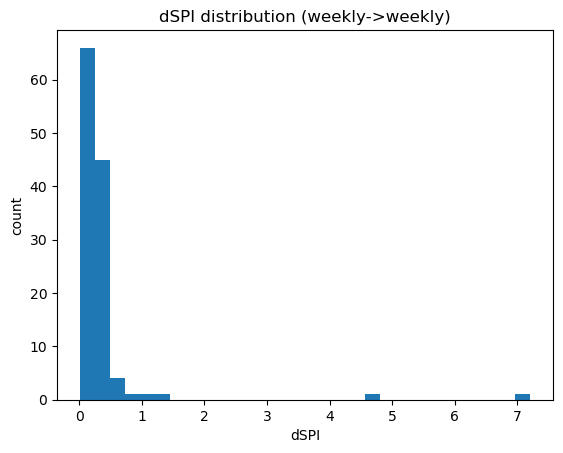

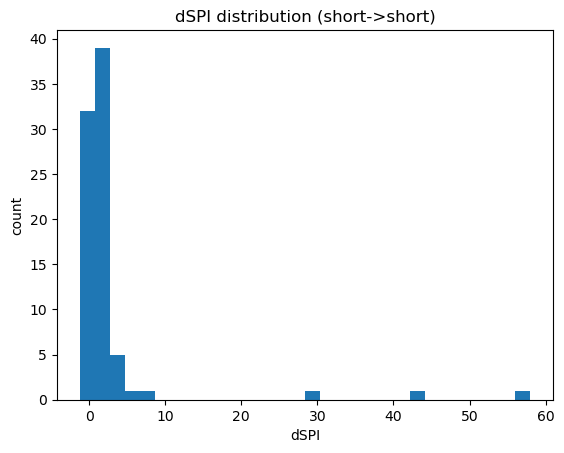

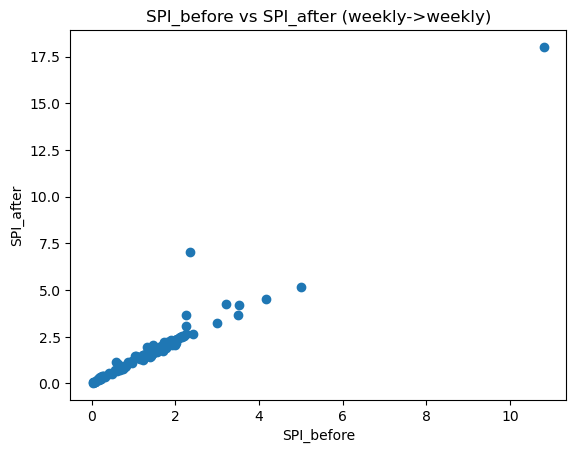

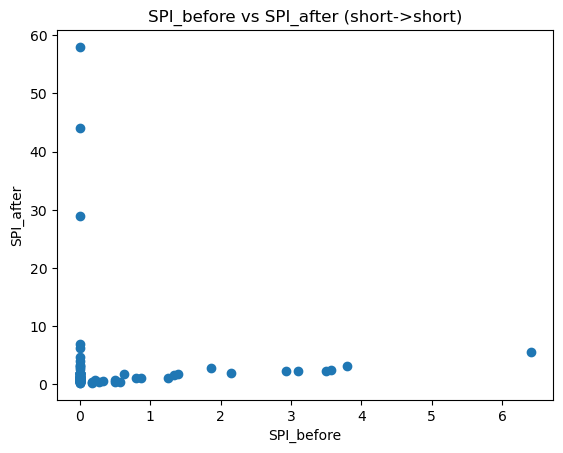

In [12]:
# ===== Cell 4: 統計検定（dSPIが正に偏るか？）＋簡単な可視化 =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu

# 0との差の検定に使う（0はwilcoxonの仕様上落とす）
def wilcoxon_greater_than_zero(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna()
    x_nz = x[x != 0]
    if len(x_nz) < 5:
        return {"n": int(len(x)), "n_nonzero": int(len(x_nz)), "stat": np.nan, "p": np.nan, "r": np.nan}
    stat, p = wilcoxon(x_nz, alternative="greater")

    # 効果量 r = z / sqrt(N)（zは近似）
    N = len(x_nz)
    meanW = N * (N + 1) / 4
    varW  = N * (N + 1) * (2*N + 1) / 24
    z = (stat - meanW) / np.sqrt(varW)
    r = z / np.sqrt(N)
    return {"n": int(len(x)), "n_nonzero": int(len(x_nz)), "stat": float(stat), "p": float(p), "r": float(r)}

def summarize_group(df, name):
    out = {}
    out["group"] = name
    out["rows"] = len(df)
    out["pos_rate(dSPI>0)"] = float((df["dSPI"] > 0).mean()) if len(df) else np.nan
    out["median_dSPI"] = float(df["dSPI"].median()) if len(df) else np.nan
    out["mean_dSPI"] = float(df["dSPI"].mean()) if len(df) else np.nan
    out["median_SPI_before"] = float(df["SPI_before"].median()) if len(df) else np.nan
    out["median_SPI_after"] = float(df["SPI_after"].median()) if len(df) else np.nan

    w = wilcoxon_greater_than_zero(df["dSPI"]) if len(df) else {"n":0,"n_nonzero":0,"stat":np.nan,"p":np.nan,"r":np.nan}
    out.update({f"wilcoxon_{k}": v for k, v in w.items()})
    return out

# ---- グループ分割（セル3で作った mode_transition を前提）
weekly = events[events["mode_transition"] == "weekly->weekly"].copy()
short  = events[events["mode_transition"] == "short->short"].copy()
switch = events[events["mode_transition"] == "short->weekly"].copy()  # 任意：切替イベント

summary = pd.DataFrame([
    summarize_group(weekly, "weekly->weekly"),
    summarize_group(short,  "short->short"),
    summarize_group(switch, "short->weekly"),
])

display(summary)

# ---- 週（weekly）と短期（short）で dSPI の分布が違うか（参考：両側検定）
# ※母集団が違うので「参考」扱いが無難。主仮説は各群で dSPI>0 かどうか（上のWilcoxon）。
x = pd.to_numeric(weekly["dSPI"], errors="coerce").dropna()
y = pd.to_numeric(short["dSPI"], errors="coerce").dropna()
if len(x) >= 5 and len(y) >= 5:
    u_stat, p_u = mannwhitneyu(x, y, alternative="two-sided")
    print(f"[Mann-Whitney U] weekly vs short : U={u_stat:.1f}, p={p_u:.3g}, n_weekly={len(x)}, n_short={len(y)}")
else:
    print("[Mann-Whitney U] サンプル不足でスキップ")

# ---- 可視化：dSPIのヒスト（週と短期）
plt.figure()
plt.hist(x, bins=30)
plt.title("dSPI distribution (weekly->weekly)")
plt.xlabel("dSPI")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(y, bins=30)
plt.title("dSPI distribution (short->short)")
plt.xlabel("dSPI")
plt.ylabel("count")
plt.show()

# ---- 可視化：SPI_before vs SPI_after（週と短期）
plt.figure()
plt.scatter(weekly["SPI_before"], weekly["SPI_after"])
plt.title("SPI_before vs SPI_after (weekly->weekly)")
plt.xlabel("SPI_before")
plt.ylabel("SPI_after")
plt.show()

plt.figure()
plt.scatter(short["SPI_before"], short["SPI_after"])
plt.title("SPI_before vs SPI_after (short->short)")
plt.xlabel("SPI_before")
plt.ylabel("SPI_after")
plt.show()


In [13]:
# === Cell 5b: ログイン有無ごとの前後比較（平均/中央値/効果量） ===
def summarize_dspi_events(events_df, label):
    subset = events_df.copy()
    stats = {
        "label": label,
        "rows": len(subset),
        "mean_dSPI": float(subset["dSPI"].mean()) if len(subset) else np.nan,
        "median_dSPI": float(subset["dSPI"].median()) if len(subset) else np.nan,
        "mean_SPI_before": float(subset["SPI_before"].mean()) if len(subset) else np.nan,
        "median_SPI_before": float(subset["SPI_before"].median()) if len(subset) else np.nan,
        "mean_SPI_after": float(subset["SPI_after"].mean()) if len(subset) else np.nan,
        "median_SPI_after": float(subset["SPI_after"].median()) if len(subset) else np.nan,
    }
    w = wilcoxon_greater_than_zero(subset["dSPI"]) if len(subset) else {"n":0,"n_nonzero":0,"stat":np.nan,"p":np.nan,"r":np.nan}
    stats.update({f"wilcoxon_{k}": v for k, v in w.items()})
    return stats

summary_login = pd.DataFrame([
    summarize_dspi_events(events, "all events"),
    summarize_dspi_events(events[events["loginFlag"] == 1], "login events"),
])

display(summary_login)


,label,rows,mean_dSPI,median_dSPI,mean_SPI_before,median_SPI_before,mean_SPI_after,median_SPI_after,wilcoxon_n,wilcoxon_n_nonzero,wilcoxon_stat,wilcoxon_p,wilcoxon_r
0,all events,223,1.057401,0.256325,1.093151,0.826343,2.150552,1.396825,223,223,21028.5,4.195544e-19,0.592934
1,login events,152,1.398984,0.239019,1.035254,0.628434,2.434238,1.310401,152,152,9520.0,4.639985e-12,0.552932


In [14]:
# SPI_after >= 1 のイベントを抽出
good_spi = events[events["SPI_after"] >= 1]

# モード別の内訳
display(
    good_spi.groupby("mode_transition")[["SPI_before", "SPI_after", "dSPI"]]
    .describe()
)


SPI_before                                                   \
                     count      mean       std      min       25%       50%   
mode_transition                                                               
short->short          55.0  0.610493  1.313800  0.00000  0.000000  0.000000   
short->weekly          6.0  3.133400  1.663910  1.25000  2.154767  2.540712   
weekly->weekly        87.0  1.861843  1.187226  0.58217  1.404710  1.654762   

                                     SPI_after            ...            \
                      75%        max     count      mean  ...       75%   
mode_transition                                           ...             
short->short     0.312500   6.402116      55.0  4.294456  ...  2.523810   
short->weekly    4.452128   5.353591       6.0  1.557419  ...  1.991768   
weekly->weekly   1.986816  10.813187      87.0  2.294425  ...  2.292639   

                            dSPI                                           \
                       max count      mean        std       min       25%   
mode_transition                                                             
short->short     58.000000  55.0  3.683963  10.204808 -1.250000  1.000000   
short->weekly     2.173639   6.0 -1.575981   1.388711 -3.452381 -2.682608   
weekly->weekly   18.021978  87.0  0.432581   0.895256  0.004904  0.181991   

                                                
                      50%       75%        max  
mode_transition                                 
short->short     1.093750  2.000000  58.000000  
short->weekly   -0.988144 -0.697948  -0.178571  
weekly->weekly   0.270254  0.364679   7.208791  

[3 rows x 24 columns]

In [15]:
events.groupby("mode_transition")["SPI_after"].apply(
    lambda x: (x >= 1).mean()
)


mode_transition
short->short      0.679012
short->weekly     0.272727
weekly->weekly    0.725000
Name: SPI_after, dtype: float64